## Preparation of Libraries

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

In [6]:
os.getcwd()

'C:\\Users\\yumun'

##Mount Google Drive

##Separately Save the Folders

In [7]:
train_dir = 'train'
validation_dir = 'val'
test_dir = 'test'

##Check a random image

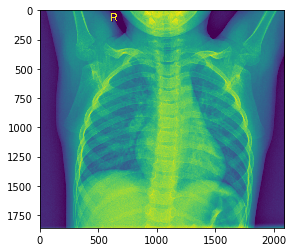

In [8]:
img = mpimg.imread(train_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [9]:
K.clear_session()

NUM_CLASSES = 2




##Start working on InceptionV3

In [10]:
def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

In [11]:
model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)


87916544/87910968 [==============================] - 4s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 512) dtype=float32, numpy=
 array([[-0.04691742,  0.01060252,  0.0413137 , ...,  0.02708507,
          0.00241582,  0.01014382],
        [ 0.00319945, -0.01298774, -0.02849578, ...,  0.03742446,
         -0.03835752, -0.01754872],
        [ 0.00736002,  0.04445651, -0.0106688 , ...,  0.03118764,
          0.01343803,  0.02831562],
        ...,
        [ 0.00348753, -0.01612038,  0.04233497, ..., -0.02239805,
         -0.04768115, -0.04762061],
        [ 0.00077055, -0.03797225, -0.02468749, ..., -0.0338837 ,
          0.02411623, -0.03356858],
        [ 0.03892569,  0.01916628,  0.03640383, ..., -0.02428206,
         -0.01429869,  0.01328382]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

##Optimize

In [14]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [18]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5232 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)


[1.93921423 0.6737059 ]


In [20]:
# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=5,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=22)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
33/33 [==============================] - 381s 12s/step - loss: 0.5712 - accuracy: 0.7410 - val_loss: 0.5943 - val_accuracy: 0.6429
Epoch 2/5
33/33 [==============================] - 376s 11s/step - loss: 0.4260 - accuracy: 0.8026 - val_loss: 0.7813 - val_accuracy: 0.7143
Epoch 3/5
33/33 [==============================] - 378s 11s/step - loss: 0.3264 - accuracy: 0.8624 - val_loss: 1.6034 - val_accuracy: 0.5714
Epoch 4/5
33/33 [==============================] - 385s 12s/step - loss: 0.2998 - accuracy: 0.8869 - val_loss: 1.5242 - val_accuracy: 0.5714
Epoch 5/5
33/33 [==============================] - 388s 12s/step - loss: 0.2609 - accuracy: 0.8939 - val_loss: 0.9937 - val_accuracy: 0.7143
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: pneumonia_v0.0.1.hd5\assets


In [26]:
os.getcwd()

'C:\\Users\\yumun'

In [32]:
dirName = 'Week_04'
 
os.mkdir(dirName)


In [37]:
os.getcwd()

'C:\\Users\\yumun'

In [38]:
os.mv {MODEL_FILE} ('Week_04')

SyntaxError: invalid syntax (<ipython-input-38-c62938184278>, line 1)

In [36]:
MODEL_FILE = 'Week_04/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)

OSError: SavedModel file does not exist at: Week_04/{MODEL_FILE}/{saved_model.pbtxt|saved_model.pb}

In [39]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 33s 33s/step - loss: 1.3078 - accuracy: 0.7067
Loss     : 1.31  
Accuracy : 70.67%


In [40]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

1/1 [==============================] - 30s 30s/step


In [41]:
import random

num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 70.67%
-----------------------------------


In [42]:
result  = model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.3078091144561768
Accuracy: 0.7067308


In [43]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

##Predictions

In [ ]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

##Results

In [ ]:
predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

InteractiveShell.ast_node_interactivity = "all"

results

##Confusion Matrix

In [ ]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

##Image Examples of Predictions

In [ ]:
def plot_val_xrays(width=width//2, height=height//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Incorrect diagnosis
    1: 'green' # Correct diagnosis
  }

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == pred else 0
        
    diagnosis_type = 'Pneumonia' if test_generator.classes[i] == 1 else 'Normal'
    diagnosis_conf = vl_score[i][1] * 100.0
    diagnosis = 'Diagnosis: {}\n{:.1f}% Confidence'.format(diagnosis_type,
                                                           diagnosis_conf)

    im = get_resized_image(images_test[i], width, height)[:, :, 0]
    ax[idx//cols,idx%cols].imshow(im, cmap='bone')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_xrays()